In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2

In [2]:
import os
import sys
import warnings
import numpy

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))

In [3]:
from tensortrade.rewards import SimpleProfitStrategy
from tensortrade.actions import DiscreteActionStrategy
from tensortrade.exchanges.simulated import FBMExchange
from tensortrade.features.stationarity import FractionalDifference
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features import FeaturePipeline

normalize = MinMaxNormalizer(inplace=True)
difference = FractionalDifference(difference_order=0.6,
                                  inplace=True)
feature_pipeline = FeaturePipeline(steps=[normalize, difference])

reward_strategy = SimpleProfitStrategy()
action_strategy = DiscreteActionStrategy(n_actions=20, instrument_symbol='ETH/BTC')

exchange = FBMExchange(base_instrument='BTC',
                       timeframe='1h',
                       should_pretransform_obs=True)

In [4]:
from tensortrade.environments import TradingEnvironment
from tensortrade.strategies import TensorforceTradingStrategy

network_spec = [
    dict(type='dense', size=128, activation="tanh"),
    dict(type='dense', size=64, activation="tanh"),
    dict(type='dense', size=32, activation="tanh")
]

agent_spec = {
    "type": "ppo",
    "learning_rate": 1e-4,
    "discount": 0.99,
    "likelihood_ratio_clipping": 0.2,
    "estimate_terminal": False,
    "max_episode_timesteps": 2000,
    "network": network_spec,
    "batch_size": 10,
    "update_frequency": "never"
}

environment = TradingEnvironment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy,
                                 feature_pipeline=feature_pipeline)

strategy = TensorforceTradingStrategy(environment=environment, agent_spec=agent_spec)

In [5]:
performance = strategy.run(episodes=10, evaluation=False)

performance[-5:]

Episodes: 100%|██████████| 10/10 [03:30, reward=-2480.93, ts/ep=1666, sec/ep=21.01, ms/ts=12.6, agent=12.2%]

Finished running strategy.
Total episodes: 10 (16660 timesteps).
Average reward: -2480.927010642792.


,balance,net_worth
1140,555.342174,2182.129451
1141,418.226026,2177.213989
1142,1737.446304,2177.544226
1143,29.296107,2172.084486
1144,14.897395,2177.174143


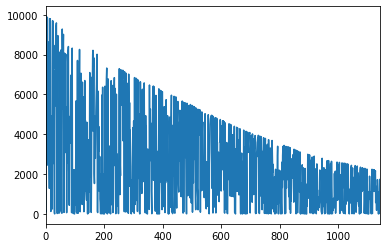

In [6]:
performance.balance.plot()

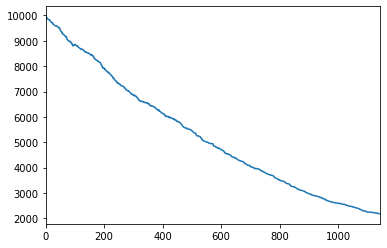

In [7]:
performance.net_worth.plot()

In [ ]:
strategy.save_agent(directory='agents')